## **Problem Statement**
Understanding customer sentiment has always played a pivotal role in driving business success - especially in today's competitive marketplace. As online reviews continue to influence consumer decisions, there is a growing need to harness the power of data to enhance product performance and customer satisfaction. A Sentiment Analyzer is one such example of a data-driven Machine Learning solution that could be used to enable objective decision making.

## **Caveat**
In this notebook, **we will attempt to perform Sentiment Analysis not directly using the text of the reviews** (which would require text preprocessing techniques), but **only using tabular summary statistics / metadata of the reviews**, using features such as the length of the review, the numerical rating provided, the number of times that product was purchased, and the number of unique words in that review. **An indirect method of Sentiment Analysis like this**, while sometimes used as part of the stack as a feature provider for more complex methods, is **primarily meant to illustrate the effectiveness of Machine Learning techniques on tabular data**, and not meant to be a comprehensive representation of how Sentiment Analysis is done.

## **Dataset**

Here's a description of each column in the dataset:

- **product_id:** A unique identifier for each product in the dataset.
- **Review_Length:** The length (number of words or characters) of the customer review for the product.
- **Rating:** The numerical rating given by the customer for the product, often on a scale of 1 to 5.
- **Avg_Word_Length:** The average length of words in the customer review, calculated by dividing the total number of characters by the total number of words.
- **Sentiment:** A binary indicator of customer sentiment. It is encoded as 0 for positive sentiment and 1 for negative sentiment.
- **Times_purchased:** The number of times the product has been purchased, reflecting its popularity or demand.
- **unique_words:** The count of unique words used in the customer review, indicating the diversity of vocabulary and potential richness of content.

This dataset's combination of attributes provides a view of customer interactions with products. By leveraging these numerical features, the aim is to predict sentiment, allowing businesses to gauge customer satisfaction and tailor strategies to enhance their offerings.

## **Reading the Dataset**

In [ ]:
# Libraries to help with reading and manipulating data
import pandas as pd
import numpy as np

# Libraries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# to build and check model performance
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Modify directory address as required to ensure the CSV file is found
prod_df = pd.read_csv("../content/drive/My Drive/product_df_f.csv")

In [ ]:
prod_df.sample(5)

,Unnamed: 0,product_id,Review_Length,Rating,Avg_Word_Length,Sentiment,Times_purchased,unique_words
3526,3526,27,217,5,3,1,23,26
2787,2787,16,245,4,12,1,47,44
3043,3043,33,152,4,10,0,18,21
3008,3008,39,155,4,12,1,11,21
197,197,16,265,4,6,1,49,47


## **Checking the shape of the dataset**

In [ ]:
prod_df.shape

(5000, 8)

**This dataset comprises of 5000 rows and 8 columns**, where each row represents a review and the specific data about it, while the 8 columns contain numerical attributes such as product information, review characteristics, sentiment, and purchase metrics.

## **Checking the columns and info**

In [ ]:
prod_df.columns

Index(['Unnamed: 0', 'product_id', 'Review_Length', 'Rating',
       'Avg_Word_Length', 'Sentiment', 'Times_purchased', 'unique_words'],
      dtype='object')

In [ ]:
prod_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   Unnamed: 0       5000 non-null   int64
 1   product_id       5000 non-null   int64
 2   Review_Length    5000 non-null   int64
 3   Rating           5000 non-null   int64
 4   Avg_Word_Length  5000 non-null   int64
 5   Sentiment        5000 non-null   int64
 6   Times_purchased  5000 non-null   int64
 7   unique_words     5000 non-null   int64
dtypes: int64(8)
memory usage: 312.6 KB


* There are **8 numeric (*int64* type) columns** in the data
* **The target variable is the Sentiment**, which is of *int64* type



## **Summary Statistics**

In [ ]:
prod_df.describe()

,Unnamed: 0,product_id,Review_Length,Rating,Avg_Word_Length,Sentiment,Times_purchased,unique_words
count,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,2499.500000,30.067800,154.23900,3.003000,7.501600,0.260600,12.113600,33.859400
std,1443.520003,11.824126,84.71091,1.407333,2.885006,0.439006,15.207424,24.200975
min,0.000000,10.000000,10.00000,1.000000,3.000000,0.000000,1.000000,1.000000
25%,1249.750000,20.000000,81.00000,2.000000,5.000000,0.000000,2.000000,15.000000
50%,2499.500000,30.000000,155.00000,3.000000,7.000000,0.000000,3.000000,26.000000
75%,3749.250000,40.000000,227.00000,4.000000,10.000000,1.000000,21.000000,48.000000
max,4999.000000,50.000000,300.00000,5.000000,12.000000,1.000000,50.000000,120.000000


- The **average review length** is approximately 154 words.
- The reviews have a **standard deviation of around 84.7 words**.
- The **minimum review length is 10 words, while the maximum is 300 words**.
- On average, products are purchased around 12 times.
- Reviews contain an average of about 33.9 unique words.
- **Around 74% of reviews have a sentiment of 0 (positive), while the remaining 26% have a sentiment of 1 (negative) - showing this is an imbalanced data set**.
- The mean average word length in reviews is roughly 7.50 characters.
- The standard deviation of word lengths is approximately 2.9 characters.

In [ ]:
prod_df.duplicated().sum()

0

In [ ]:
prod_df.isnull().sum()

Unnamed: 0         0
product_id         0
Review_Length      0
Rating             0
Avg_Word_Length    0
Sentiment          0
Times_purchased    0
unique_words       0
dtype: int64

There are **no duplicate or missing values in the data.**

## **Exploratory Data Analysis (EDA)**

In [ ]:
def histogram_boxplot(data, feature, figsize=(15, 10), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (15,10))
    kde: whether to show the density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a triangle will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

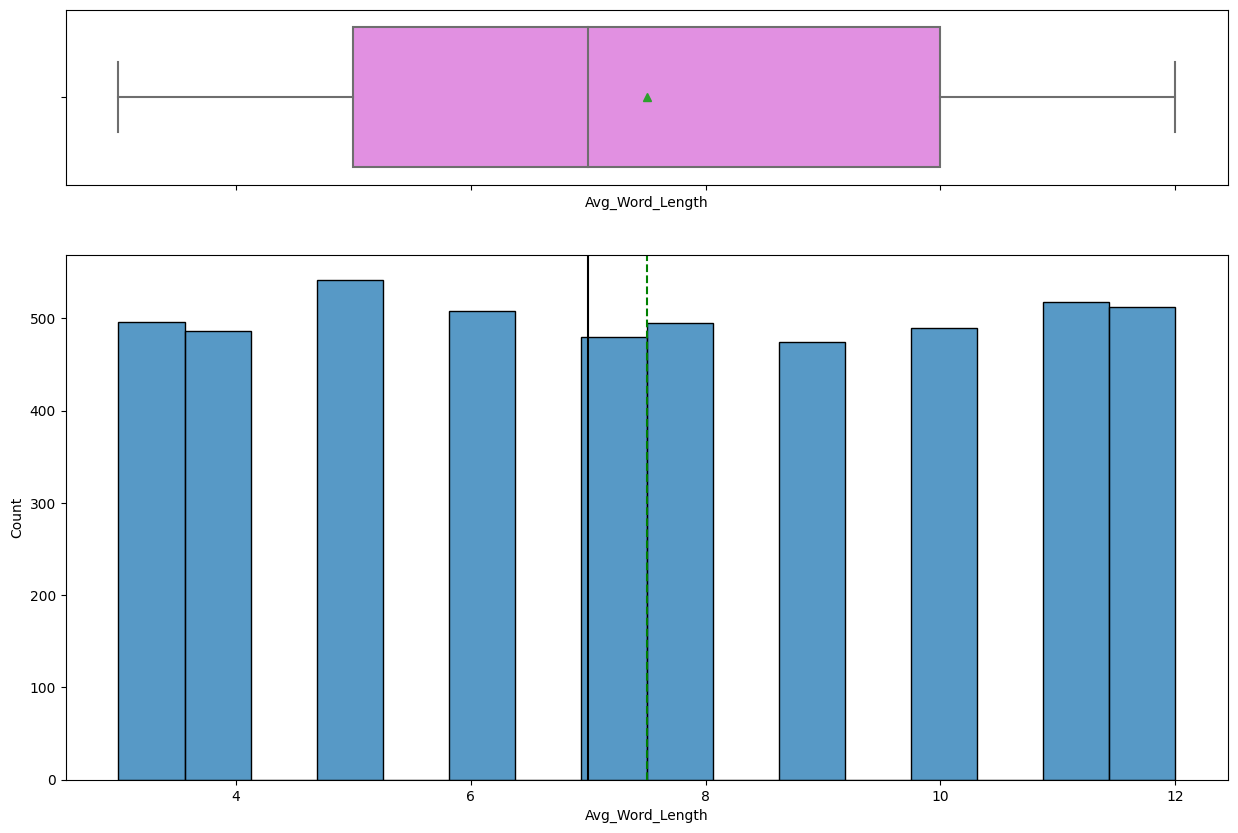

In [ ]:
histogram_boxplot(prod_df, "Avg_Word_Length")

- The mean average word length in the reviews is **approximately 7.50 characters.**
- This suggests that, **on average, reviewers use a moderate number of characters** to express their thoughts about the products.

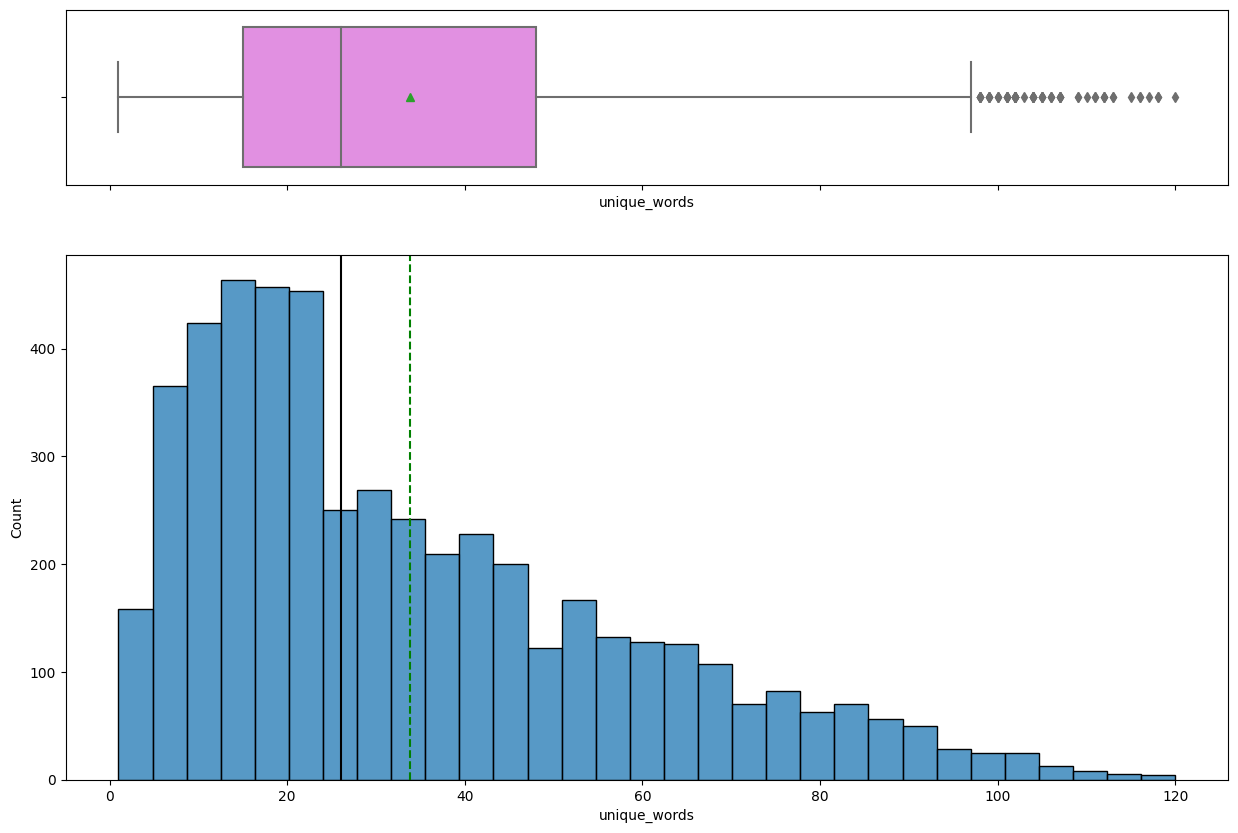

In [ ]:
histogram_boxplot(prod_df, "unique_words")

- In the 'Unique words' column, a few outliers are present.

These outliers hold interesting implications, particularly in the context of Sentiment Analysis for product reviews. Unique words, those that stand out from the common vocabulary, can offer valuable insights into the nuances of sentiment expressed by reviewers. These distinctive words might encapsulate specific emotions, experiences, or opinions that contribute to the richness of the review sentiment.

 When considering the removal of these outliers, it's essential to recognize that they could contain essential information that aids in accurately discerning the sentiment of a review. By excluding them as outliers, there's a potential trade-off where valuable sentiments might be disregarded, affecting the overall performance of sentiment prediction models. Striking the right balance between handling outliers and retaining valuable sentiment cues is pivotal for achieving robust and accurate sentiment analysis results.

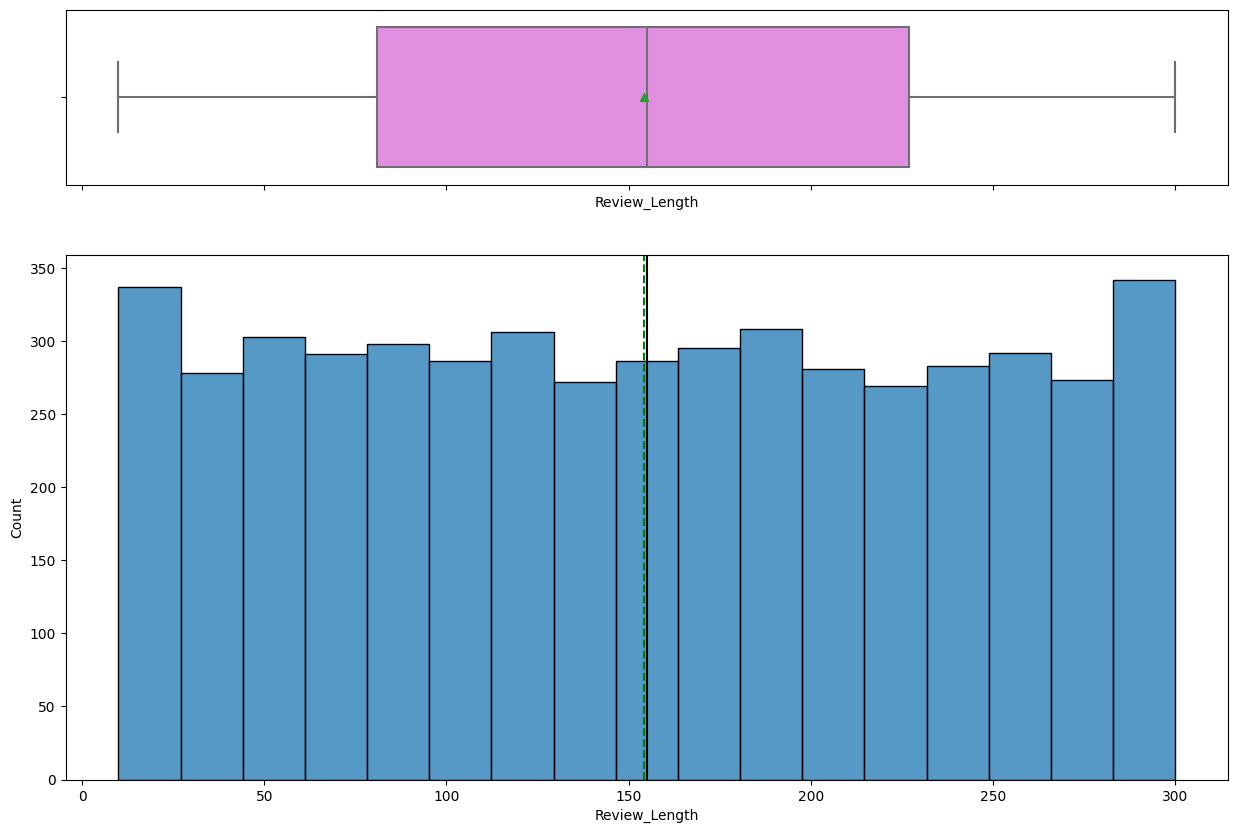

In [ ]:
histogram_boxplot(prod_df, "Review_Length")

- It can be observed that **the average length of reviews hovers around 154 characters.** Notably, a significant portion of the reviews falls within specific character ranges, contributing to interesting patterns in review length distribution. **A substantial cluster of reviews spans from 20 to 30 characters, which suggests that concise and succinct feedback is a common trend among users**, as users don't want to spend too much time giving reviews.
- Additionally, **another cluster appears in the range of 270 to 300 characters**, indicating that despite the general trend, **a notable number of users (who might more deeply care about sharing their experiences) opt for more extensive and detailed expressions when sharing their experiences.**

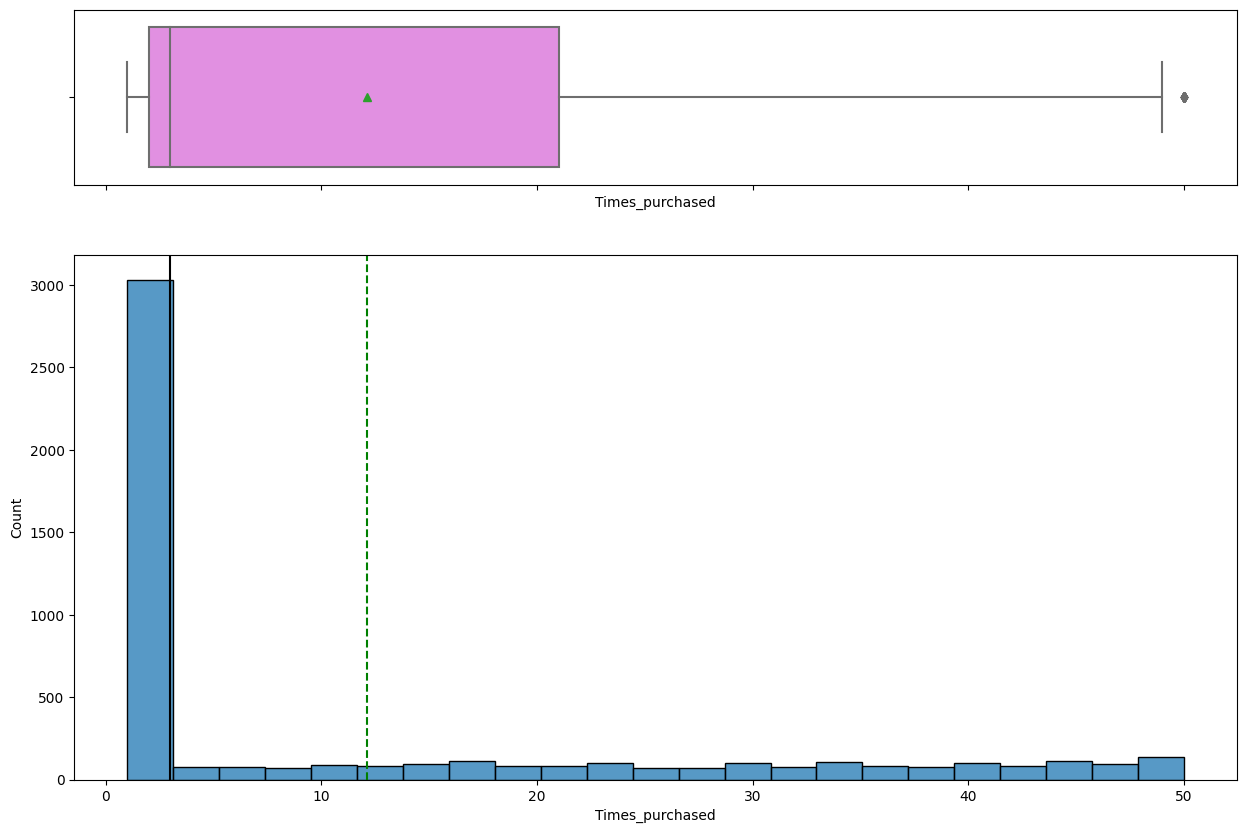

In [ ]:
histogram_boxplot(prod_df, "Times_purchased")

-  It appears that **products with negative reviews tend to be purchased less frequently**, which is as expected.

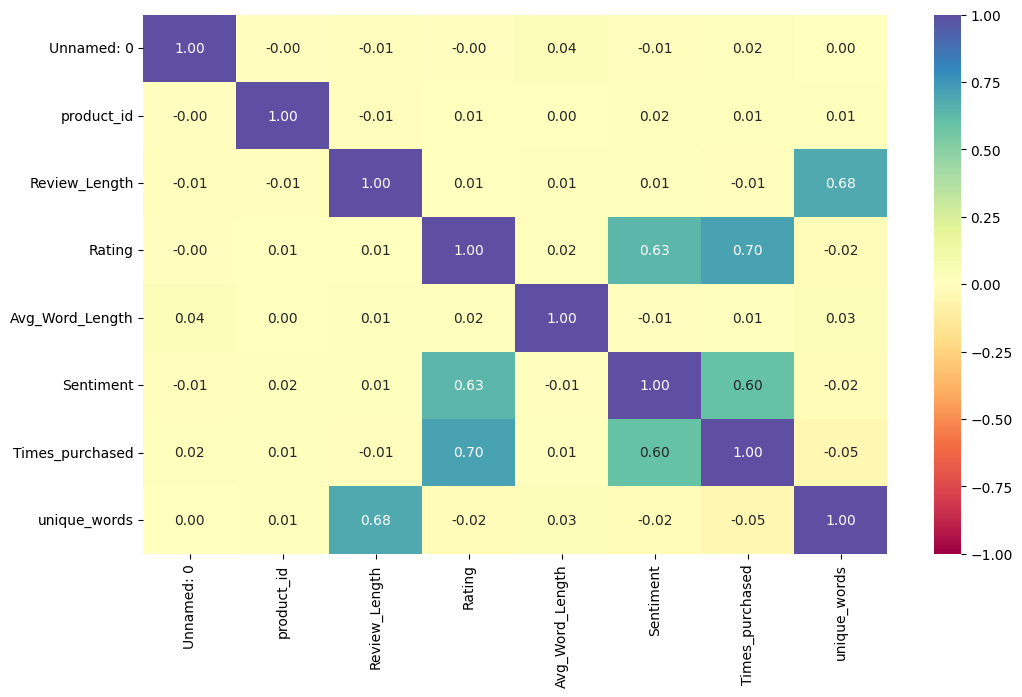

In [ ]:
num_cols = prod_df.select_dtypes(include=np.number).columns.tolist()
plt.figure(figsize=(12, 7))
sns.heatmap(
    prod_df[num_cols].corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral"
)
plt.show()

### **Pairplot Reviews**

- **Rating vs. Sentiment:** **There is a moderately strong positive correlation (0.634314)** between the product rating and the sentiment expressed in the review. This indicates that higher-rated products tend to have more positive sentiment associated with them, which is as expected.

- **Sentiment vs. Times Purchased:** There is a moderately strong positive correlation (0.596061) between the sentiment of the review and the number of times the product has been purchased. This could indicate that products with positive sentiment tend to be purchased more often.

- **Review Length vs. unique_words:** There is a moderately strong positive correlation (0.679789) between the length of the review and the count of unique words. Longer reviews tend to have more unique words, which can be expected.

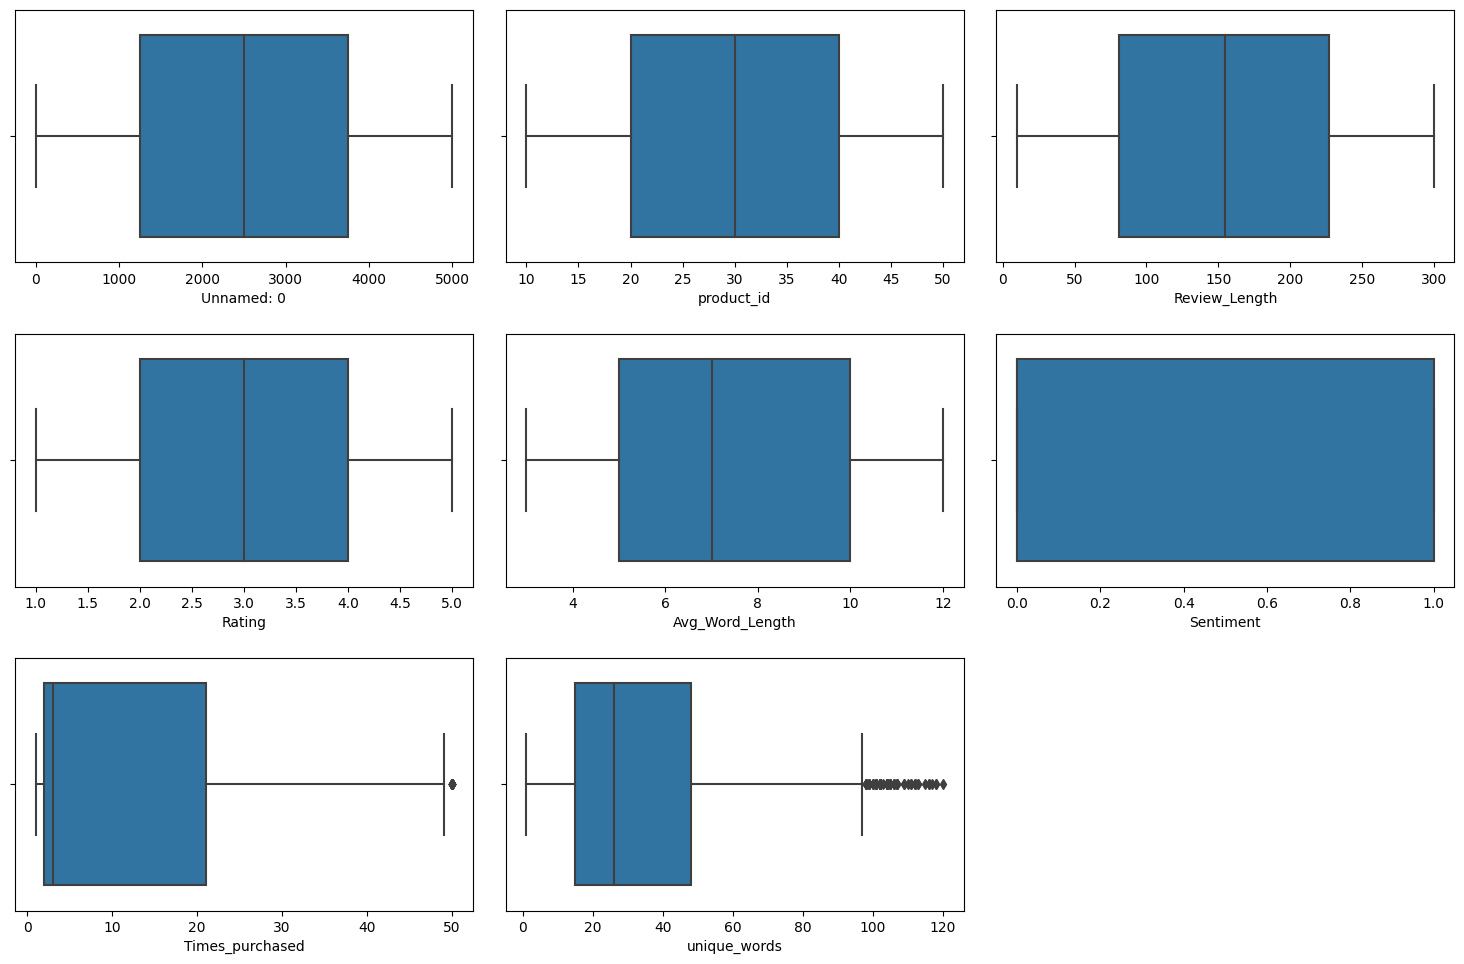

In [ ]:
# Get the list of numerical columns from the DataFrame
num_cols = prod_df.select_dtypes(include=np.number).columns.tolist()

# Create a figure for the box plot grid with specified size
plt.figure(figsize=(15, 10))

# Loop through each numerical variable and create a subplot
for i, variable in enumerate(num_cols):
    # Create a subplot within the grid (3 rows, 3 columns)
    plt.subplot(3, 3, i + 1)

    # Create a box plot using Seaborn, visualize data distribution and outliers
    sns.boxplot(data=prod_df, x=variable)

    # Adjust the layout of subplots for better spacing
    plt.tight_layout(pad=2)

# Display the entire grid of box plots
plt.show()


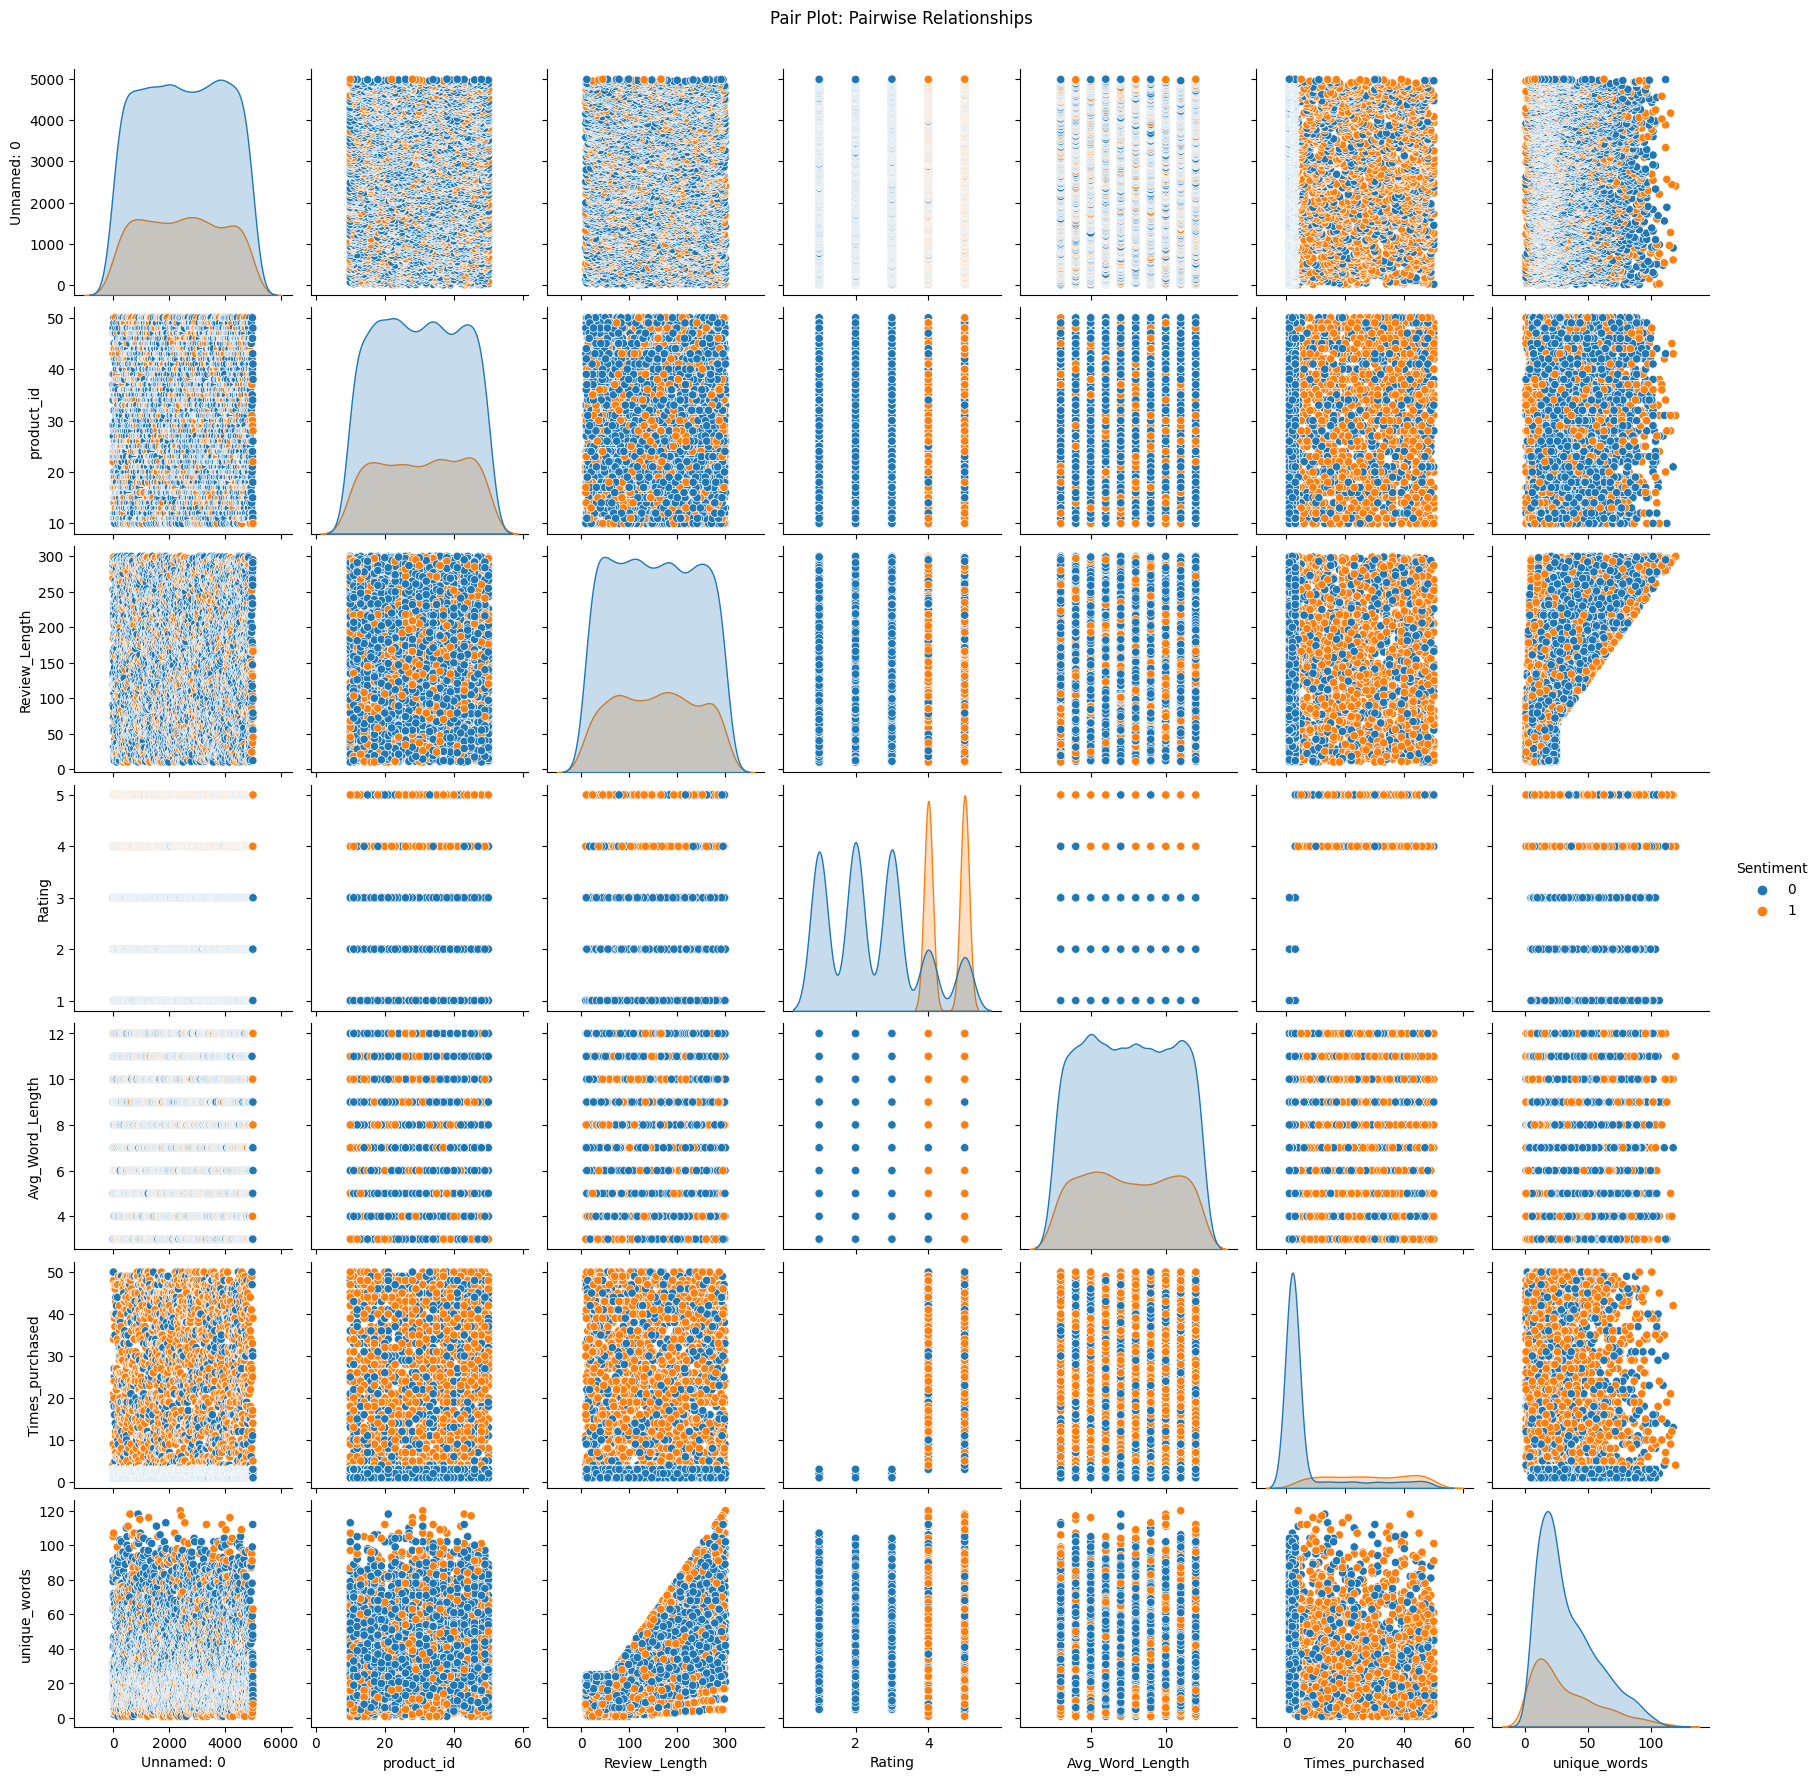

In [ ]:
sns.pairplot(prod_df, hue="Sentiment")
plt.suptitle("Pair Plot: Pairwise Relationships", y=1.02)
plt.show()

- The diagonal histograms show the distribution of individual variables, indicating their ranges and potential skewness.
- **For ex: The presence of multiple valleys and peaks suggests that the distribution of review lengths is not unimodal (having a single peak) but rather bimodal or multimodal (having two or more distinct peaks).** This indicates that there might be distinct groups or patterns within the data that result in different ranges of review lengths. This indicates some users might prefer to write very short reviews, while others might write more detailed and longer ones.


## **Model Building**

The **Random Forest** is an Ensemble Machine Learning method that combines multiple decision trees to make predictions. Its ability to handle complex relationships within data, manage overfitting, and provide feature importance insights means it stands a good chance of detecting the predictive patterns in the data.

In [ ]:
# Split the data into features (X) and the target variable (y)
X = prod_df.drop(columns=['Sentiment','Unnamed: 0'])
y = prod_df['Sentiment']

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model to the training data
rf_model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

**Splitting Data:**The code segment begins by splitting the dataset into training and testing sets using the train_test_split function. This function takes the feature matrix X and target vector y as input, along with test_size to specify the proportion of data to allocate to the test set. The random_state parameter ensures reproducibility by setting the random seed.

**Initializing Random Forest Model:** An instance of the RandomForestClassifier model is initialized with hyperparameters. In this case, n_estimators is set to 100, indicating the number of decision trees in the forest. The random_state parameter ensures consistent randomization across runs.

**Model Fitting:** The initialized random forest model (rf_model) is then fitted to the training data using the fit method. This step involves training each decision tree in the forest on a different subset of the training data. The model learns patterns and relationships between features and target labels during this process.

In [ ]:
# Predict sentiments for the test data
y_pred = rf_model.predict(X_test)

# Calculate accuracy and F1-score
accuracy = accuracy_score(y_test, y_pred)
f1score = f1_score(y_test, y_pred, average='weighted')

print("Accuracy:", accuracy)
print("F1-Score:", f1score)

Accuracy: 0.831
F1-Score: 0.8356459636363637


**The achieved accuracy of 83.1%** indicates that the model is correctly classifying sentiment for a significant portion of the test instances.

**The F1-score of 83.6% further demonstrates the model's effectiveness in balancing precision and recall**, showcasing its ability to handle both positive and negative sentiment classifications well - which has **extra significance given this is an Imbalanced Classification problem.**

These results suggest that the predictive model is performing favorably in discerning sentiments from the given numerical attributes. The high accuracy and F1-score indicate the model's capacity to generalize well to new, unseen data.



## **Confusion Matrix**

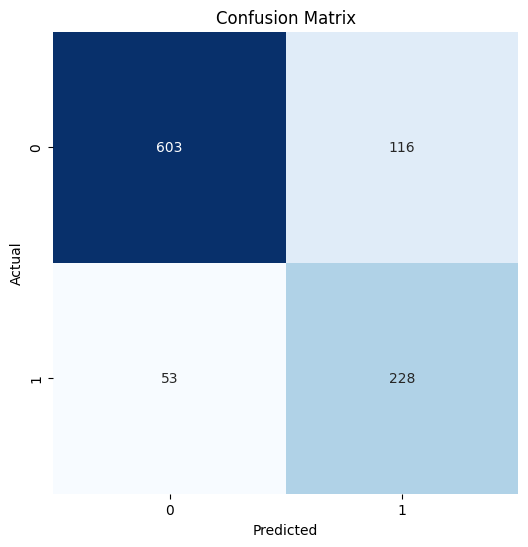

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
# Plot the confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

- **The top-left cell (603) represents the count of True Positives (TP)**, indicating that 603 instances were correctly predicted as the negative class. **The bottom-right cell (228), on the other hand, represents the count of True Negatives (TN)**, indicating that 228 instances were correctly predicted as the positive class. As such, 603 + 228, 831 instances (out of 1000 instances in the Test dataset, or 83.1%), have had their sentiments correctly identified by the ML model.

- **The top-right cell (116) represents the count of False Negatives (FN)** , indicating that **116 instances were wrongly predicted as the positive class when they actually belong to the negative class.** These instances were originally positive in sentiment but were misclassified as negative in sentiment by the model.

- **The bottom-left cell (53) represents the count of False Positives (FP)**, indicating that 53 instances were wrongly predicted as the negative class when they actually belong to the positive class.

- Given the imbalance in the dataset, where positive classes dominate, the model seems to perform reasonably well in identifying the majority class (positive sentiment). However, it seems to struggle more with the minority class (negative sentiment), as indicated by the Confusion Matrix.